In [4]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
%matplotlib inline

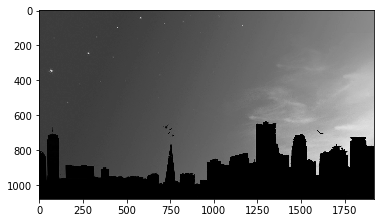

In [5]:
img = cv2.imread('1.jpg',0)
plt.imshow(img,cmap = 'gray')
plt.show()


In [6]:
scaleArea = []
input = img
for _ in range(4):
    sigma = (_+1)/math.sqrt(2)
    new_octave = []
    to_be_blurred = input
#     new_octave.append(to_be_blurred)
    for _ in range(5):
        blurred = cv2.GaussianBlur(to_be_blurred, (3,3), sigma)
        new_octave.append(blurred)
        to_be_blurred = blurred
        sigma *= math.sqrt(2)
    scaleArea.append(new_octave)
    width = int(input.shape[1] * 50 / 100)
    height = int(input.shape[0] * 50 / 100)
    input = cv2.resize(input, (width, height), interpolation=cv2.INTER_AREA)

In [7]:
print("scaleArea.shape = (%d,%d)" %(len(scaleArea), len(scaleArea[0])))

scaleArea.shape = (4,5)


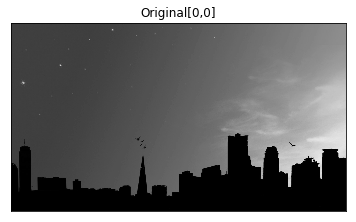

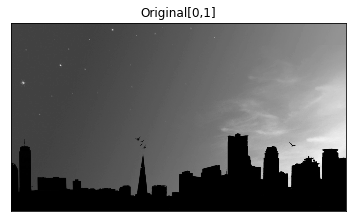

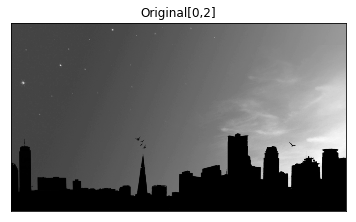

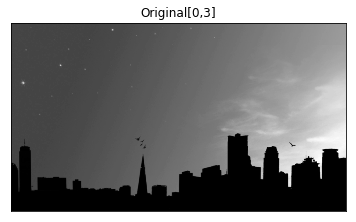

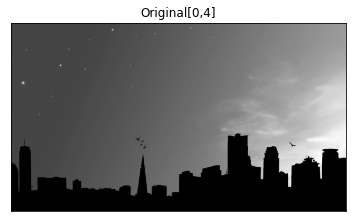

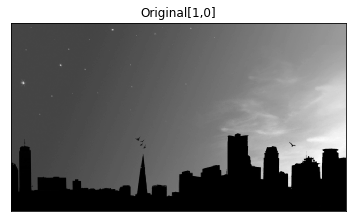

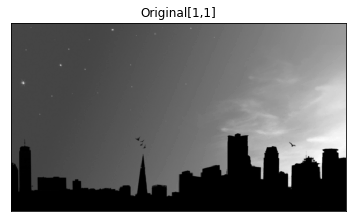

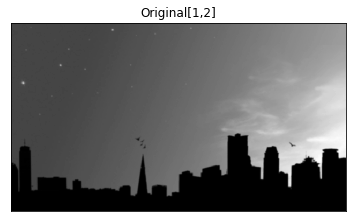

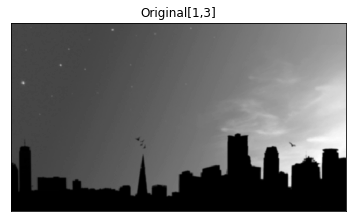

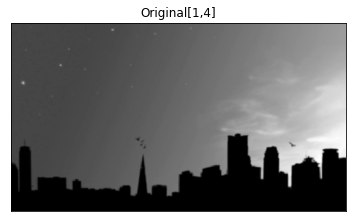

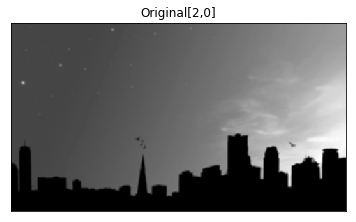

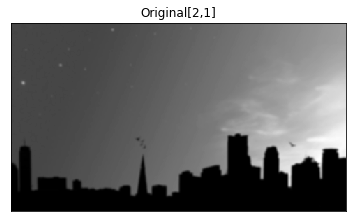

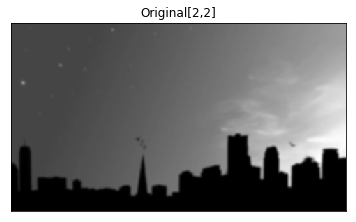

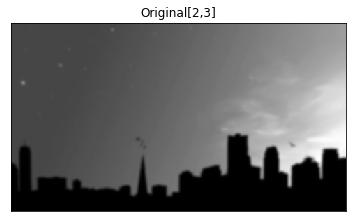

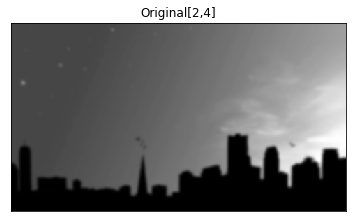

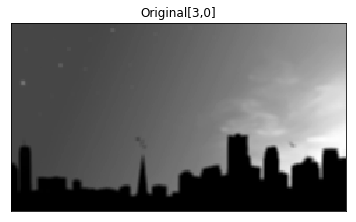

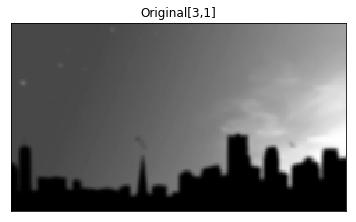

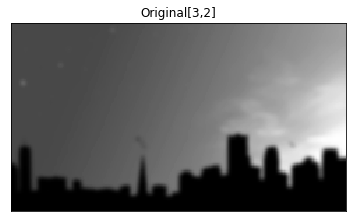

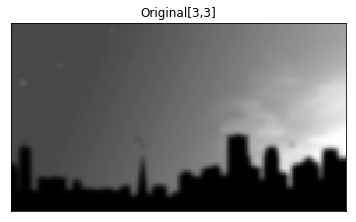

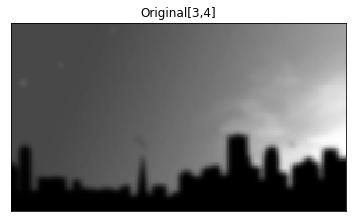

In [8]:
for j in range(len(scaleArea)):
    for i in range(len(scaleArea[j])):
        plt.imshow(scaleArea[j][i],cmap = 'gray')
        plt.title('Original[%d,%d]' % (j, i)), plt.xticks([]), plt.yticks([])
        plt.show()

In [9]:
log = []
for i in range(len(scaleArea)):
    new_log = []
    for j in range(len(scaleArea[i]) - 1):
        new_log.append(scaleArea[i][j+1] - scaleArea[i][j])
    log.append(new_log)

In [10]:
print("log.shape = (%d,%d)" % (len(log),len(log[0]))) 

log.shape = (4,4)


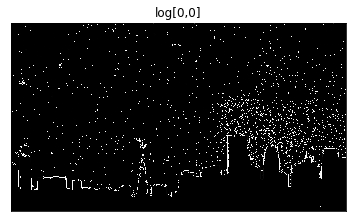

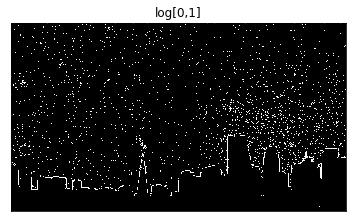

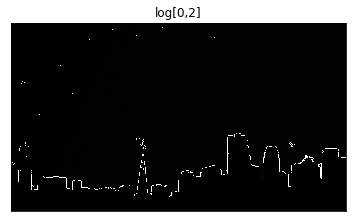

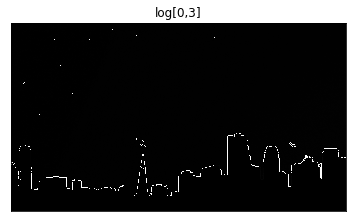

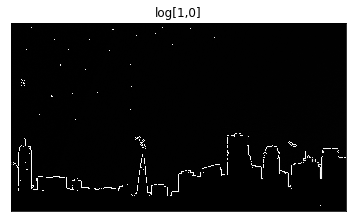

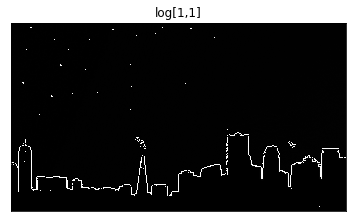

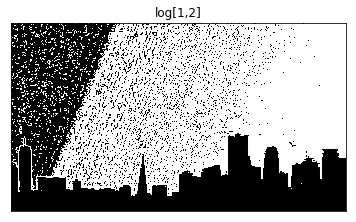

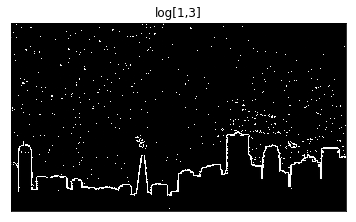

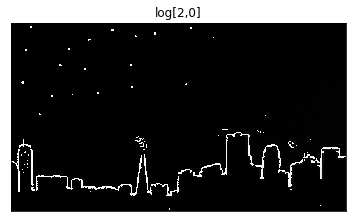

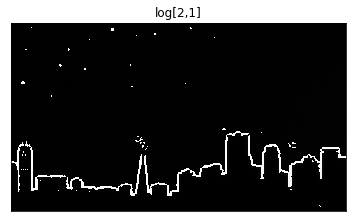

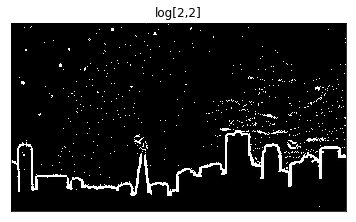

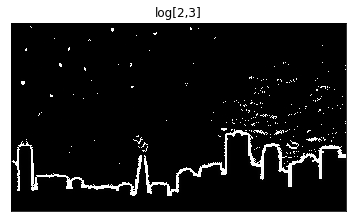

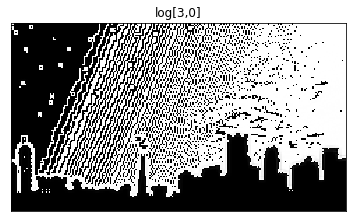

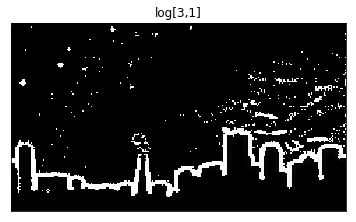

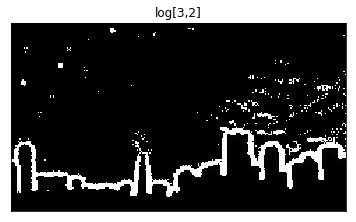

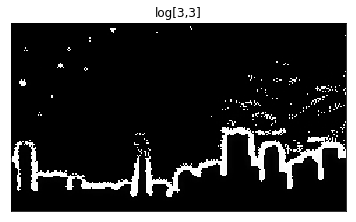

In [11]:
for i in range(len(log)):
    for j in range(len(log[i])):
        plt.imshow(log[i][j],cmap = 'gray')
        plt.title('log[%d,%d]' % (i, j)), plt.xticks([]), plt.yticks([])
        plt.show()

In [12]:
# log = [[np.zeros((3,3)),np.array([[1,1,1],[0,-1,1],[1,1,1]]),np.zeros((3,3))]]
# above log is just for testing the fucntion to find the local minima and  maxima

# this link is by far most helpful (may be) in finding sub-pixel
# https://stackoverflow.com/questions/9532415/sift-taylor-expansion-working-out-subpixel-locations?rq=1

keypoints = []
for i in range(len(log)):
    keypoint = []
    for j in range(1, len(log[i]) - 1):
        new_img = np.zeros(log[i][j].shape)
        for y in range(1, int(log[i][j].shape[0]) - 1):
            for x in range(1, int(log[i][j].shape[1]) - 1):
                minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(log[i][j][y-1:y+1,x-1:x+1], mask=None)
                if minVal == log[i][j][y,x]:
                    min_minVal, min_maxVal, min_minLoc, min_maxLoc = cv2.minMaxLoc(log[i][j-1][y-1:y+1,x-1:x+1], mask=None)
                    max_minVal, max_maxVal, max_minLoc, max_maxLoc = cv2.minMaxLoc(log[i][j+1][y-1:y+1,x-1:x+1], mask=None)
                    if minVal < min_minVal and minVal < max_minVal:
                        new_img[y,x] = 255
                elif maxVal == log[i][j][y,x]:
                    min_minVal, min_maxVal, min_minLoc, min_maxLoc = cv2.minMaxLoc(log[i][j-1][y-1:y+1,x-1:x+1], mask=None)
                    max_minVal, max_maxVal, max_minLoc, max_maxLoc = cv2.minMaxLoc(log[i][j+1][y-1:y+1,x-1:x+1], mask=None)
                    if maxVal > min_maxVal and maxVal > max_maxVal:
                        new_img[y,x] = 255
                else:
                    new_img[y,x] = 0
        keypoint.append(new_img)
    keypoints.append(keypoint)

In [13]:
print("keypoints.shape = (%d,%d)" % (len(keypoints), len(keypoints[0])))

keypoints.shape = (4,2)


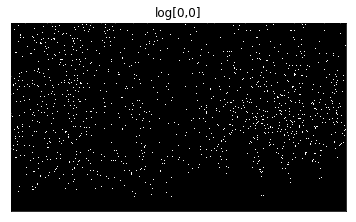

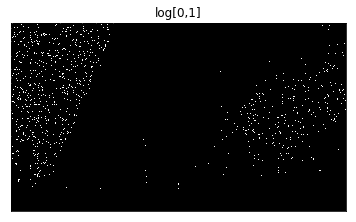

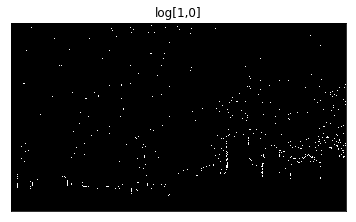

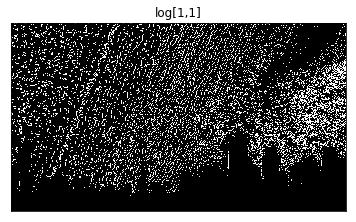

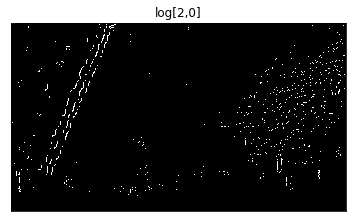

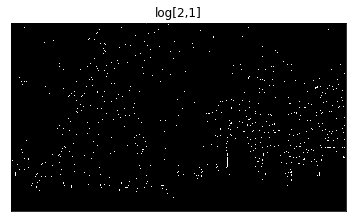

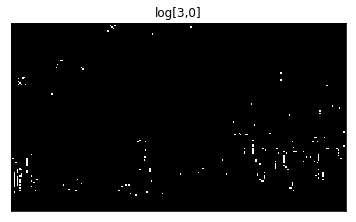

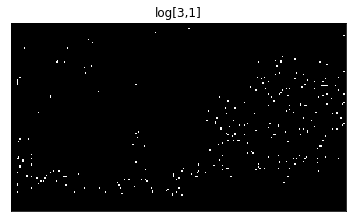

In [14]:
for i in range(len(keypoints)):
    for j in range(len(keypoints[i])):
        plt.imshow(keypoints[i][j],cmap = 'gray')
        plt.title('log[%d,%d]' % (i, j)), plt.xticks([]), plt.yticks([])
        plt.show()

In [15]:
def deriv_3D(dog, octv, intvl, r, c):
    dx = (dog[octv][intvl][r, c+1] - dog[octv][intvl][r, c-1])/2
    dy = (dog[octv][intvl][r+1, c] - dog[octv][intvl][r-1, c])/2
    ds = (dog[octv][intvl+1][r, c] - dog[octv][intvl-1][r, c])/2
    return np.array([dx, dy, ds])

In [16]:
def hessian_3D(dog, octv, intvl, r, c):
    v = dog[octv][intvl][r,c]
    dxx = dog[octv][intvl][r,c+1] + dog[octv][intvl][r,c-1] - 2*v
    dyy = dog[octv][intvl][r+1,c] + dog[octv][intvl][r-1,c] - 2*v
    dss = dog[octv][intvl+1][r,c] + dog[octv][intvl-1][r,c] - 2*v
    dxy = (dog[octv][intvl][r+1,c+1] + dog[octv][intvl][r-1,c-1] -
           dog[octv][intvl][r-1,c+1] - dog[octv][intvl][r+1,c-1] )/4
    dxs = (dog[octv][intvl+1][r,c+1] + dog[octv][intvl-1][r,c-1] -
           dog[octv][intvl-1][r,c+1] - dog[octv][intvl+1][r,c-1] )/4
    dys = (dog[octv][intvl+1][r+1,c] + dog[octv][intvl-1][r-1,c] -
           dog[octv][intvl+1][r-1,c] - dog[octv][intvl-1][r+1,c] )/4
    return np.array([[dxx, dxy, dxs],
                        [dxy, dyy, dys],
                        [dxs, dys, dss]])

In [21]:
def interp_step(dog, octv, intvl, r, c):
    dD = deriv_3D(dog, octv, intvl, r, c)
    H = hessian_3D(dog, octv, intvl, r, c)
    H_inv = np.zeros(H.T.shape)
    cv2.invert(H, H_inv, cv2.DECOMP_SVD)
    return cv2.gemm(H_inv, dD, -1, None, 0)

In [23]:
print(interp_step(log, 0, 0, 100, 100))

[[0.]
 [0.]
 [0.]]


In [417]:
def interp_contr(dog, octv, intvl, r, c):#, xi, xr, xc):
    [xi, xr, xc] = interp_step(dog, octv, intvl, r, c)
    dD = np.array([deriv_3D(dog, octv, intvl, r, c)])
    X = np.array([xc, xr, xi])
    m = np.dot(dD, X)
    contra = dog[octv][intvl][r,c] + m[0] * 2
    return contra[0]

In [418]:
# print(interp_step(log, 0, 0, 100, 100))
contra = []
for r in range(1, log[0][0].shape[0]-1):
    print(r)
    new_contra = []
    for c in range(1, log[0][0].shape[1]-1):
        new_contra.append(interp_contr(log, 0, 0, r, c))
    contra.append(np.array(new_contra))

1
2


/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  
/home/

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


In [422]:
contra = np.array(contra)
print(contra)
print(contra.shape)
x = np.linspace(1, log[0][0].shape[1]-1, log[0][0].shape[1]-2)
print(x.shape)
y = np.linspace(1, log[0][0].shape[0]-1, log[0][0].shape[0]-2)
print(y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1078, 1918)
(1918,)
(1078,)


[1.00000000e+00 2.00092851e+00 3.00185701e+00 ... 1.07699814e+03
 1.07799907e+03 1.07900000e+03]
[1.00000000e+00 2.00052165e+00 3.00104330e+00 ... 1.91699896e+03
 1.91799948e+03 1.91900000e+03]


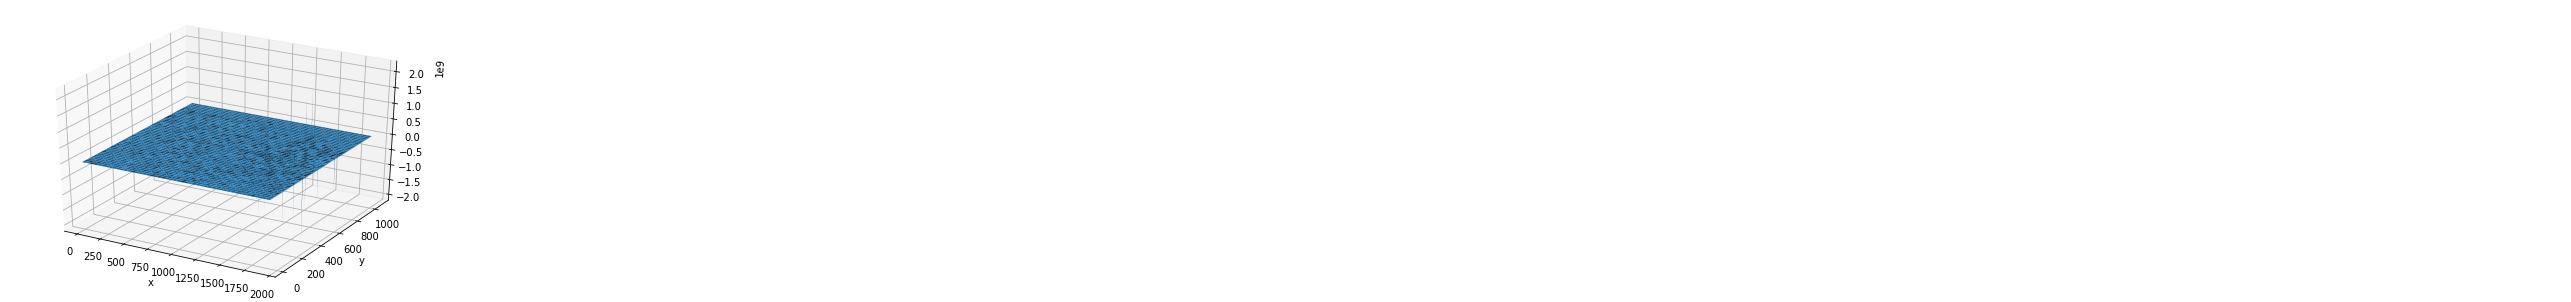

In [427]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
print(y)
print(x)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, contra)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
######################################

In [445]:
keypoints = []
for i in range(len(log)):
    keypoint = []
    for j in range(1, len(log[i]) - 1):
        new_img = np.zeros(log[i][j].shape)
        for y in range(1, int(log[i][j].shape[0]) - 1):
            for x in range(1, int(log[i][j].shape[1]) - 1):
                minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(log[i][j][y-1:y+1,x-1:x+1], mask=None)
                if minVal == log[i][j][y,x]:
                    min_minVal, min_maxVal, min_minLoc, min_maxLoc = cv2.minMaxLoc(log[i][j-1][y-1:y+1,x-1:x+1], mask=None)
                    max_minVal, max_maxVal, max_minLoc, max_maxLoc = cv2.minMaxLoc(log[i][j+1][y-1:y+1,x-1:x+1], mask=None)
                    if minVal < min_minVal and minVal < max_minVal:
                        if abs(interp_contr(log, i, j, y, x)) > 1500:
                            new_img[y,x] = 255
                        else:
                            new_img[y,x] = 0
                elif maxVal == log[i][j][y,x]:
                    min_minVal, min_maxVal, min_minLoc, min_maxLoc = cv2.minMaxLoc(log[i][j-1][y-1:y+1,x-1:x+1], mask=None)
                    max_minVal, max_maxVal, max_minLoc, max_maxLoc = cv2.minMaxLoc(log[i][j+1][y-1:y+1,x-1:x+1], mask=None)
                    if maxVal > min_maxVal and maxVal > max_maxVal:
                        if abs(interp_contr(log, i, j, y, x)) > 1500:
                            new_img[y,x] = 255
                        else:
                            new_img[y,x] = 0
                else:
                    new_img[y,x] = 0
        keypoint.append(new_img)
    keypoints.append(keypoint)

/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in ubyte_scalars
  after removing the cwd from sys.path.
/home/aion/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """
/home/aion/an

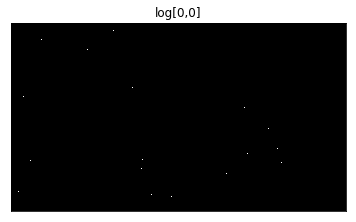

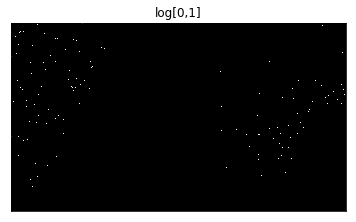

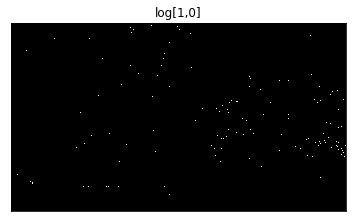

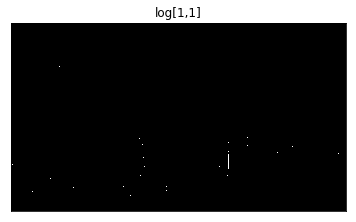

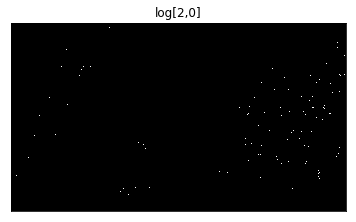

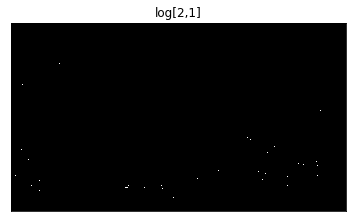

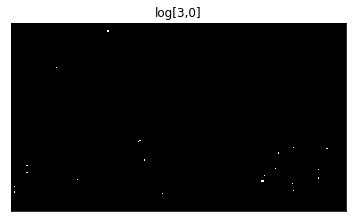

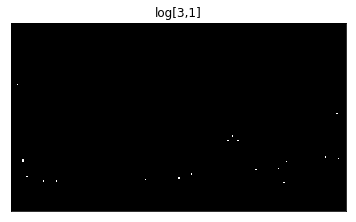

In [446]:
for i in range(len(keypoints)):
    for j in range(len(keypoints[i])):
        plt.imshow(keypoints[i][j],cmap = 'gray')
        plt.title('log[%d,%d]' % (i, j)), plt.xticks([]), plt.yticks([])
        plt.show()

In [428]:
import pickle
pickle.dump(fig, open('FigureObject.fig.pickle', 'wb'))

In [429]:
import os

scores = {} # scores is an empty dict already
target = 'FigureObject.fig.pickle'
if os.path.getsize(target) > 0:      
    with open(target, "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        scores = unpickler.load()

In [430]:
figx = pickle.load(open('FigureObject.fig.pickle', 'rb'))

EOFError: Ran out of input

In [435]:
import numpy as np
a = np.array([[1,1,1,1,1],
                 [1,0,1,2,1],
                 [1,1,1,1,1]])
c =a[0:3,0:3]
print(c[1,1])
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(c, mask=None)

0


In [436]:
print(minVal, maxVal, minLoc, maxLoc)

0.0 1.0 (1, 1) (0, 0)


In [437]:
b = np.zeros(a.shape)
c = b
print(c, c.shape, a.shape)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] (3, 5) (3, 5)


In [438]:
for y in range(a.shape[0]):
    for x in range(a.shape[1]):
        if (x,y) == minLoc or (x,y) == maxLoc:
            b[y][x] = 255
        else:
            b[y][x] = 0


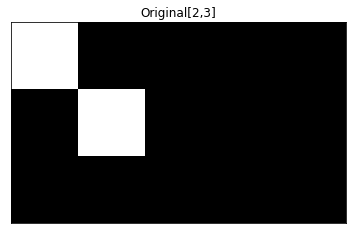

In [439]:
plt.imshow(b,cmap = 'gray')
plt.title('Original[%d,%d]' % (j, i)), plt.xticks([]), plt.yticks([])
plt.show()

In [448]:
a = numpy.empty((0))

In [449]:
print(a)

[]


In [456]:
a = numpy.append(a, [[1]])
a = numpy.append(a, [1])

In [457]:
print(a)

[1. 1. 1. 1.]
